In [1]:
import pandas as pd
import numpy as np
from scipy.stats import geom
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from itertools import product

In [2]:
data = pd.read_csv('../data/regime_features.csv')
groups_names = ['Strong Bull', 'Panic', 'Stable Bull']

# ♻️ 1. Transition Matrix Creation

At this stage, we compute the transition matrix of the Markov chain.  
The transition matrix is the foundation of a Markov chain and allows us to understand the probabilities of transitioning between states at each step of the chain.  
The formula implemented in the transition matrix normalization step is:

\\[
P_{i,j} = \frac{N_{i,j}}{\sum_{k=1}^{n} N_{i,k}}
\\]
    
**Where:**

- \$ P_{i,j} \$:     Transition probability from state \$ i \$ to state \$ j \$      
- \$ N_{i,j} \$:     Number of observed transitions from \$ i \$ to \$ j \$      
- \$ \sum_{k=1}^{n} N_{i,k} \$:     Total number of transitions from state \$ i \$    
- \$ n \$:     Total number of states (regimes)    

In [3]:
regimes = data['cluster']
n_regimes = regimes.nunique()

In [4]:
transition_matrix = np.zeros(shape=(n_regimes, n_regimes))

In [5]:
for (current, next_) in zip(regimes[:-1], regimes[1:]):
    transition_matrix[current, next_] += 1

transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

transition_df = pd.DataFrame(
    transition_matrix,
    index=[f'From {i}' for i in range(n_regimes)],
    columns=[f'To {i}' for i in range(n_regimes)]
)

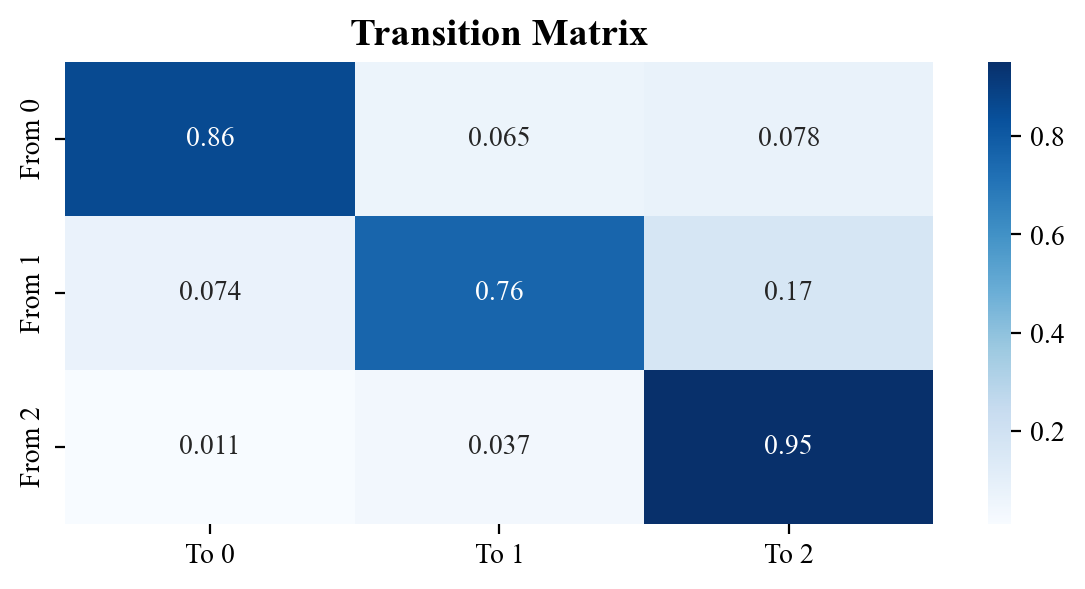

In [6]:
plt.figure(figsize=(7,3), dpi=200)
sns.heatmap(transition_df, annot=True,
           cmap='Blues')

plt.title('Transition Matrix', size=14, weight='bold')
plt.show()

# ⛓️‍💥 2. Solving the Stationary Distribution Equation

We begin with the stationary condition:

$$
\pi P = \pi
$$

To solve this, we move all terms to one side:

$$
\pi P - \pi = 0
$$

Transpose both sides to work with column vectors:

$$
(P^\top - I) \pi^\top = 0
$$

This gives a homogeneous linear system, which we can solve numerically.

To make the solution unique (as the system has infinitely many solutions), we add the normalization constraint:

$$
\sum_i \pi_i = 1
$$

This is added as an extra row to the system, and we solve:

$$
A x = b
$$

where the last row of \$ A \$ is all ones, and the last entry in \$ b \$ is 1.


In [7]:
p = transition_matrix
a = p.T - np.eye(p.shape[0])
a = np.vstack([a, np.ones(p.shape[0])])
b = np.zeros(p.shape[0])
b = np.append(b, 1)
pi = np.linalg.lstsq(a, b, rcond=None)[0]

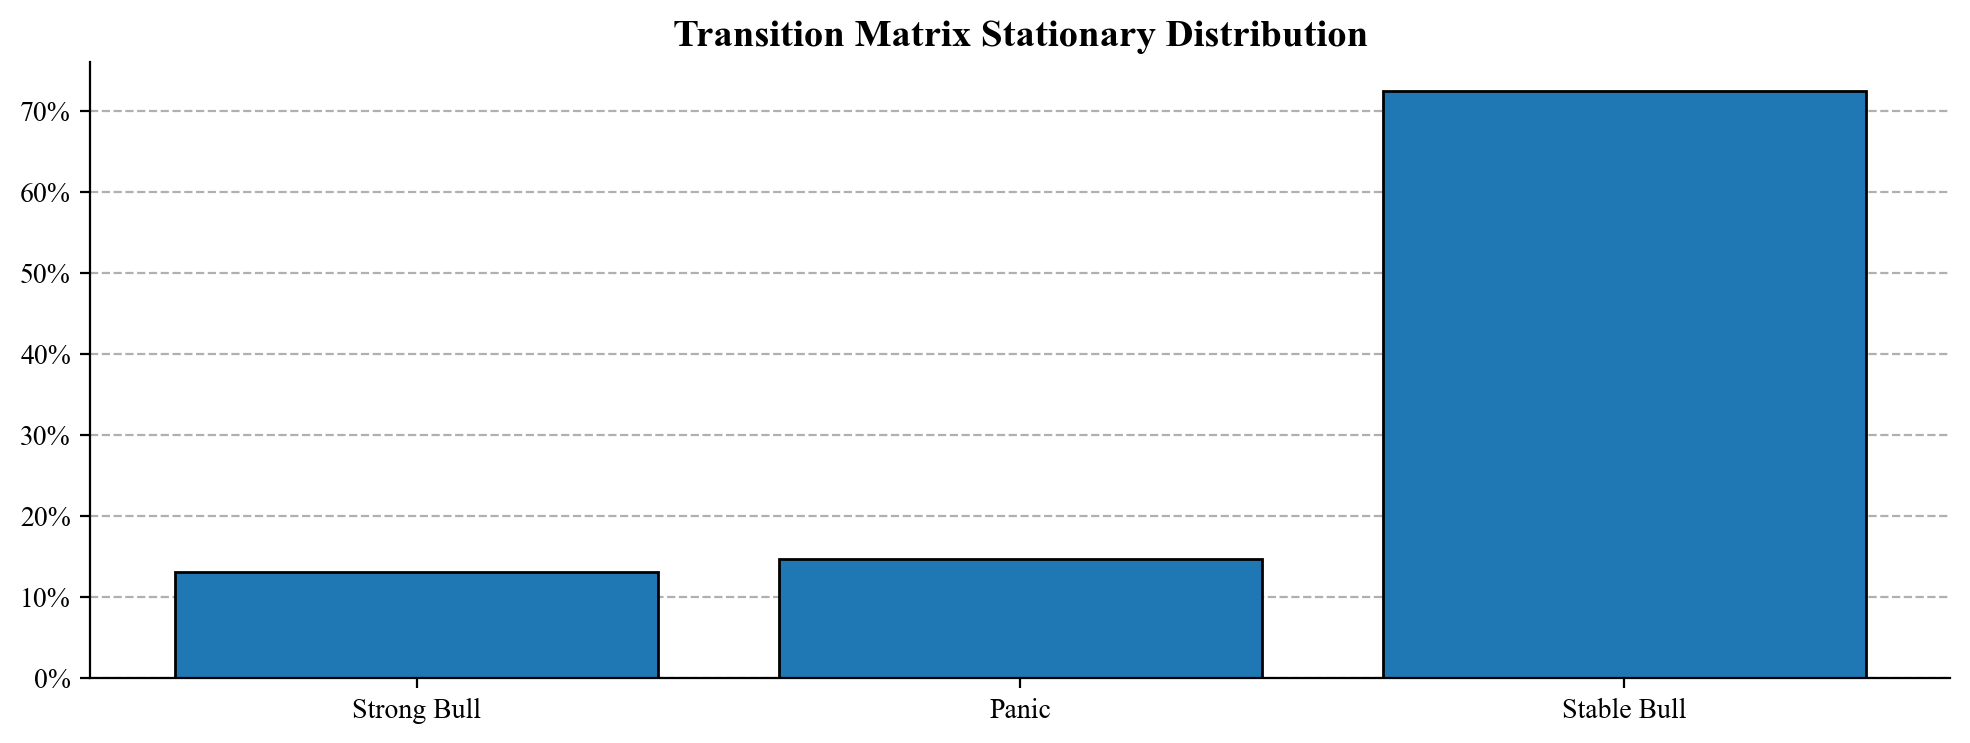

In [8]:
plt.figure(figsize=(12,4), dpi=200)
plt.bar(groups_names, pi, edgecolor='k', zorder=2)

plt.xticks(range(3))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.title('Transition Matrix Stationary Distribution', size=14, weight='bold')

plt.grid(ls='--', axis='y', zorder=0)
sns.despine()
plt.show()

## 3.1. 🔁 Dynamic Transition Analysis in Markov Chains

**This code analyzes how the transition probabilities in a Markov chain evolve over time, by computing and visualizing the values of:**

$$
P^n[i, j]
$$

**That is, the probability of being in state \( j \) after exactly \( n \) steps, given that the process started in state \( i \).**

---

#### 🧮 Step 1: Compute Matrix Powers

The function `make_transitions(transition_matrix, n_periods)` calculates the first \$ n \$ powers of the transition matrix $\ P \$, resulting in:

$$
P^1, P^2, \dots, P^n
$$

Each matrix \$ P^k \$ represents the transition probabilities after **exactly** \$ k \$ steps. The entry \$ P^k[i, j] \$ gives the probability of transitioning from state \$ i \$ to state \$ j \$ in exactly \$ k \$ steps.

---

#### 📊 Step 2: Visualize Transitions for All Pairs

The function `plot_transition_convergence(...)` plots the evolution of $P^n[i, j]$ over time $n = 1, \dots, N$,  
for any specific pair of states $i \to j$.  
It receives an optional `ax` parameter to enable plotting inside subplots.

Using `itertools.product(...)`, we iterate over all possible state pairs $(i, j) \in \{0, \dots, n{-}1\} \times \{0, \dots, n{-}1\}$,  
and display the transition probability curve of each pair in its corresponding position in an $n \times n$ subplot grid.

---

#### 🧩 Mathematical Insight

- If the rows of \$ P^n \$ converge to a constant vector \$ \pi \$, the chain reaches its **stationary distribution**.
- If the graphs \$P^n[i, j] \$ converge to fixed values across rows, it visually confirms this convergence.
- Diagonal elements \$ P^n[i, i] \$ reflect the probability of staying (or returning) to the same state.

---

#### ✅ Final Output

You get a grid of plots, each showing how the probability of being in a specific state \( j \) evolves over time, given that you started in state \( i \). This gives a complete picture of the chain’s **short-term and long-term dynamics**.

In [9]:
def make_trasitions(transition_matrix, n_periods):
    """
    Compute powers of the transition matrix for n steps ahead.

    Parameters:
        transition_matrix (np.ndarray): A square Markov transition matrix of shape (n, n)
        n_periods (int): Number of steps (n) to compute up to

    Returns:
        list of np.ndarray: List containing P^1, P^2, ..., P^n
    """

    matrix_n = []                                                # Holds transition metrices, for every period in 'n_periods'
    for n in range(1, n_periods+1):
        pn = np.linalg.matrix_power(transition_matrix, n)        # Raising the transition matrix in the power of n
        matrix_n.append(pn)
    return matrix_n

In [10]:
def plot_transition_convergence(transition_matrix, i, j, n_periods=20, ax=None):
    """
    Plot the probability of transitioning from state i to state j
    after n steps in a Markov chain (i.e., P^n[i, j] for n = 1..n_periods).

    Parameters:
        transition_matrix (np.ndarray): Square transition matrix of shape (n, n)
        i (int): Index of the starting state
        j (int): Index of the target state
        n_periods (int, optional): Number of steps to compute (default: 20)
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, uses current axis

    Returns:
        None
    """
    matrices = make_trasitions(transition_matrix, n_periods)
    probs = [pn[i, j] for pn in matrices]

    if ax is None:
        ax = plt.gca()

    ax.plot(range(1, n_periods + 1), probs, marker='o')
    ax.set_xticks(range(1, n_periods + 1, 2))
    ax.set_title(f"P^n[{i} → {j}] over time")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Probability")
    ax.grid(ls='--')
    sns.despine()

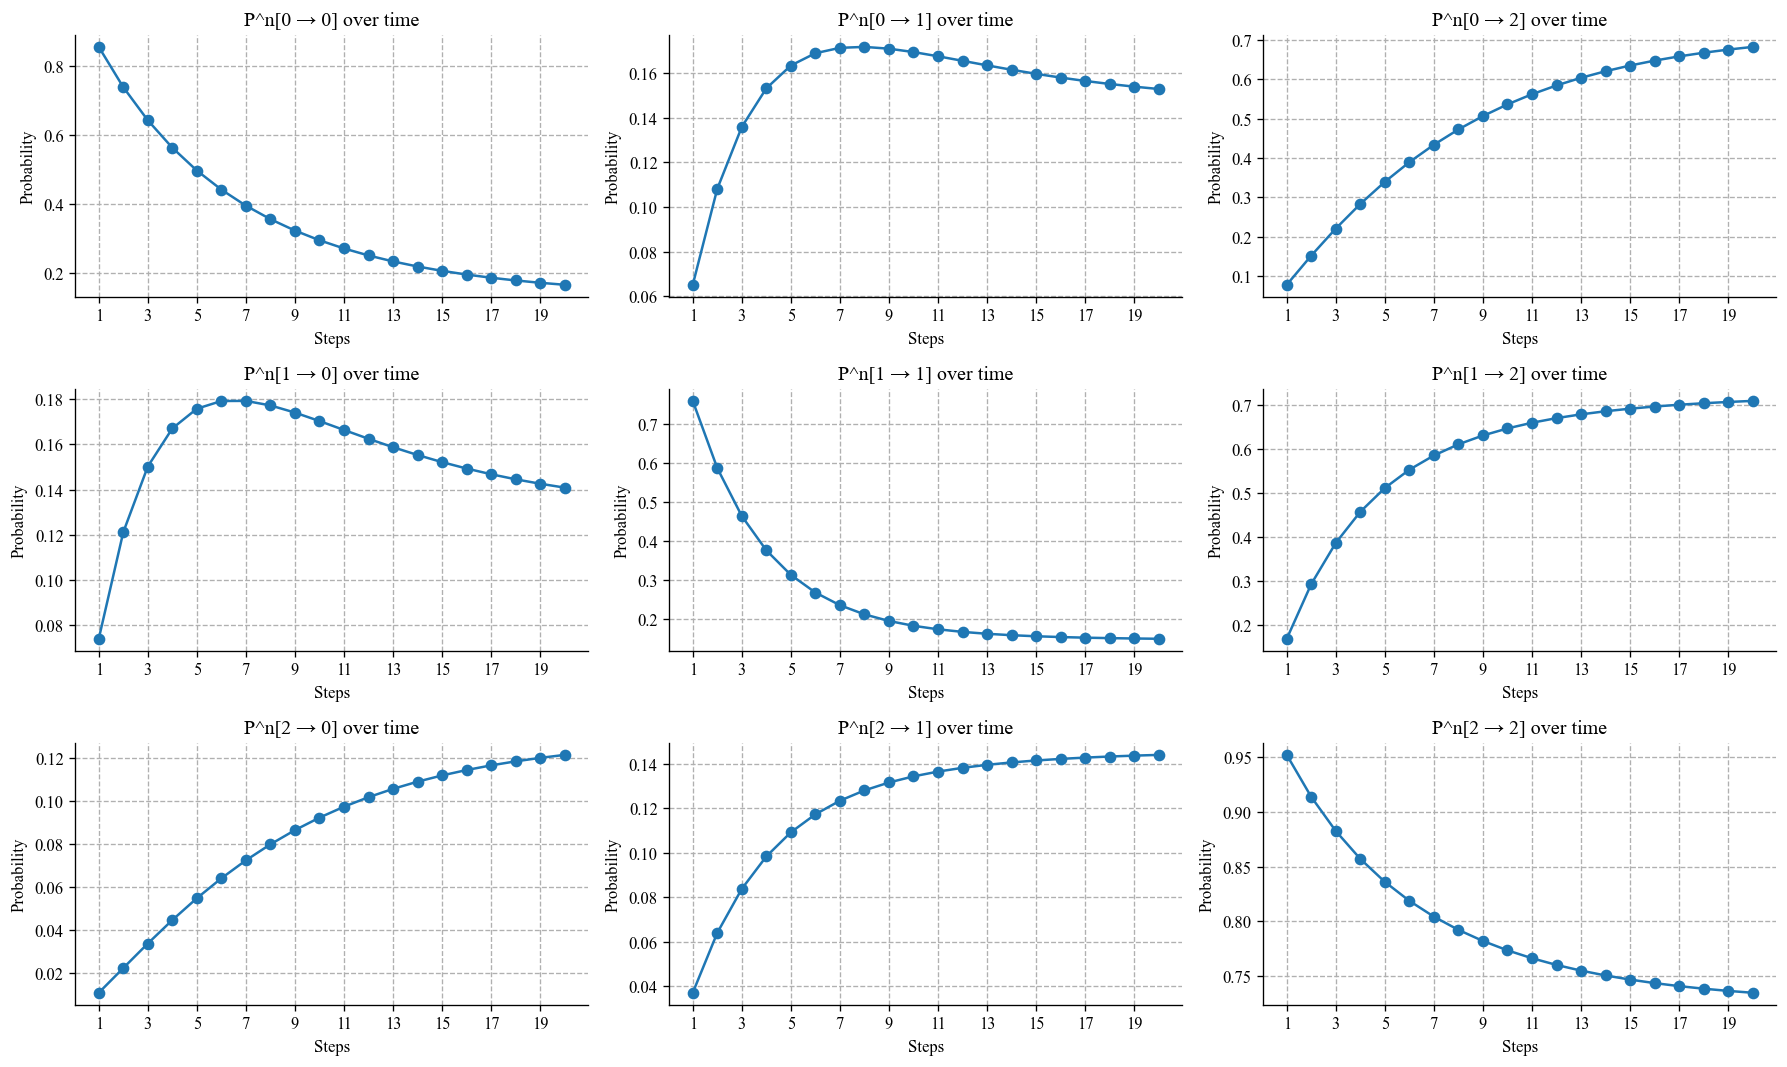

In [11]:
n_steps = 20
num_states = transition_matrix.shape[0] 

fig, axes = plt.subplots(num_states, num_states, figsize=(5*num_states, 3*num_states), dpi=120)

for i, j in product(range(num_states), repeat=2):
    ax = axes[i, j]
    plot_transition_convergence(transition_matrix, i, j, n_periods=n_steps, ax=ax)

plt.tight_layout()
plt.show()

# 🔀 3.2. Sojourn Time Distribution Analysis

In this section, we compute and visualize the **probability distribution of sojourn durations** in each state of the Markov chain.

For a given state \( i \), the **sojourn time** is the number of steps the process stays in state \( i \) before transitioning elsewhere. The probability of staying **exactly** \( k \) consecutive steps in state \( i \) is modeled as a geometric distribution:

$$
\mathbb{P}(\text{Sojourn time} = k) = (1 - p_{ii}) \cdot p_{ii}^{k - 1}
$$

Where:
- \$ p_{ii} \$ is the probability of staying in state \( i \) for one more step.
- The distribution gives the probability of **exiting the state at step \( k \)** (not before and not after).

This analysis helps us understand how "sticky" each regime is and how long the process typically stays in a given regime before switching.


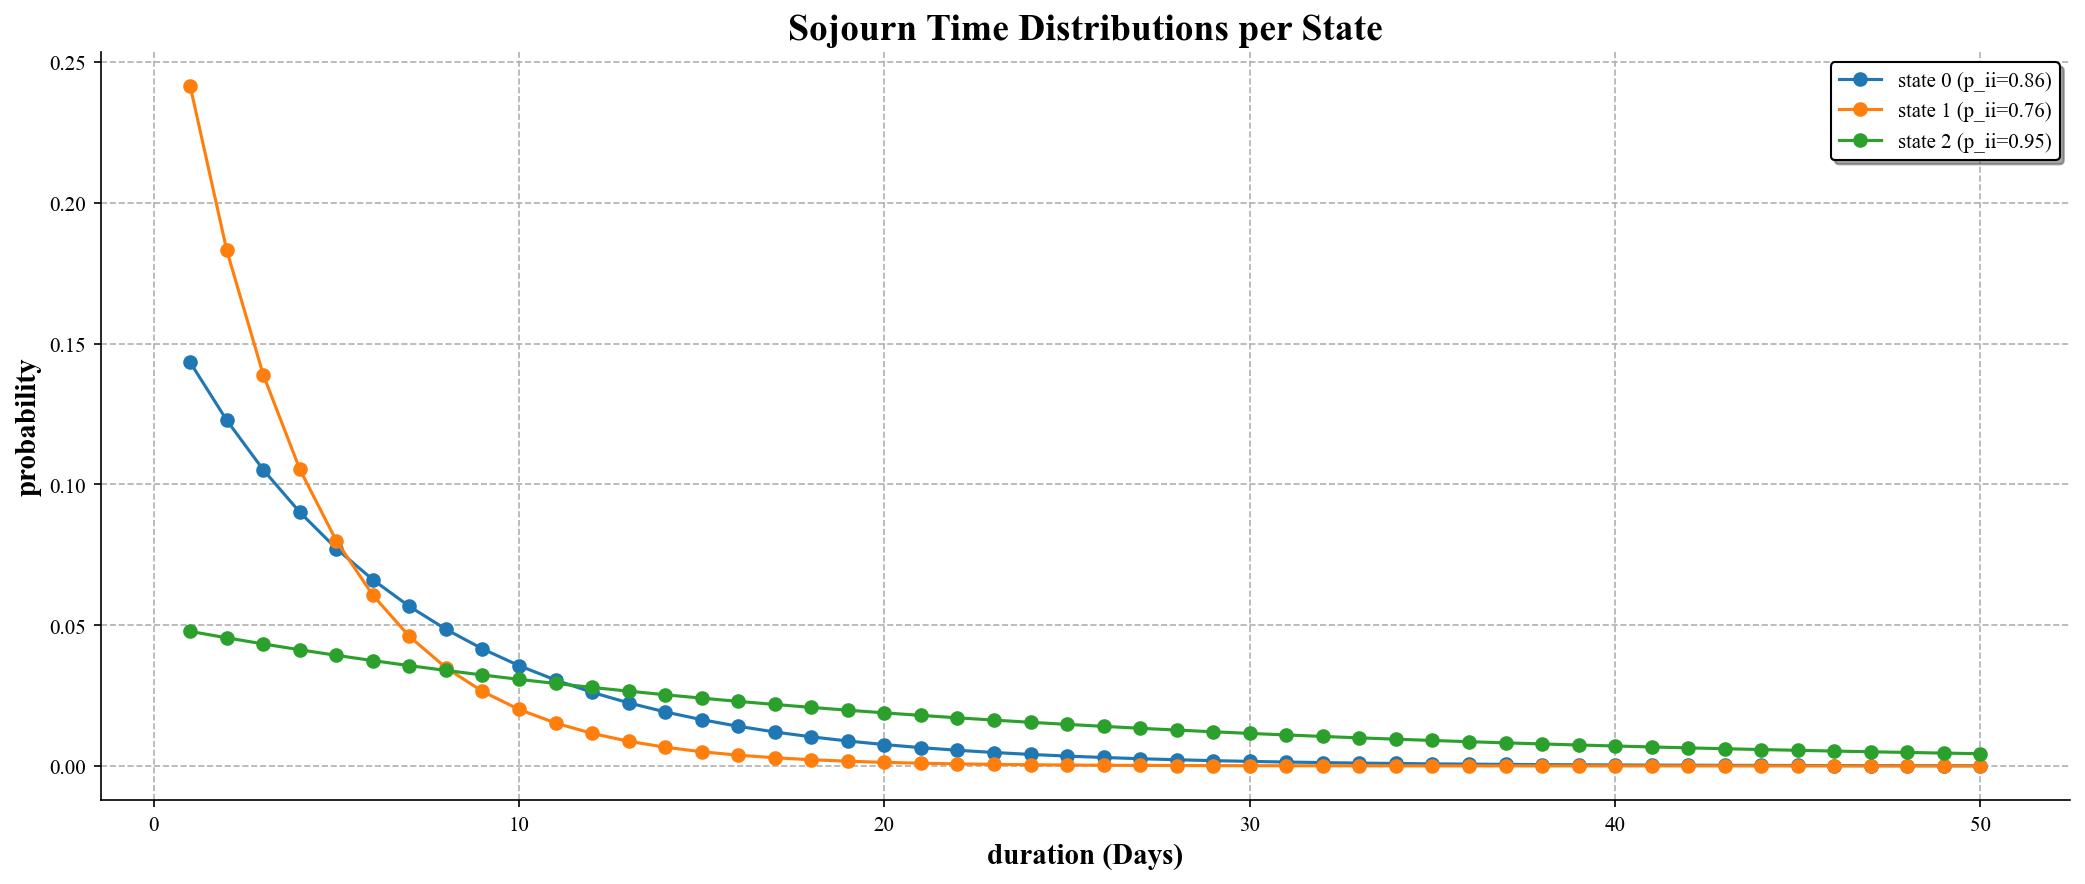

In [12]:
n_states = p.shape[0]
max_duration = 50
plt.figure(figsize=(14, 6), dpi=150)

for i in range(n_states):
    p_ii = p[i, i]
    prob = 1 - p_ii
    k_values = np.arange(1, max_duration + 1)
    probs = geom.pmf(k_values, prob)

    plt.plot(k_values, probs, marker='o', label=f'state {i} (p_ii={p_ii:.2f})')

plt.title('Sojourn Time Distributions per State', size=18, weight='bold')
plt.xlabel('duration (Days)', size=14, weight='bold')
plt.ylabel('probability', size=14, weight='bold')

plt.grid(ls='--')
plt.legend(edgecolor='k', shadow=True)
sns.despine()
plt.tight_layout()
plt.show()

# 🔄 4. Expected Return Time
In this step, we compute the **expected return time** to each state in the Markov chain.

The expected return time to a given state \$( i \)$ is the expected number of steps it takes to return to \$( i \$) **after leaving it**. It is the reciprocal of the stationary probability \$( \pi_i \$), assuming the chain is irreducible and aperiodic.

$$
\mathbb{E}[\text{return time to state } i] = \frac{1}{\pi_i}
$$

This means that the more likely a state is in the long run, the faster the chain returns to it on average.

**Example:**
Given the stationary distribution:

$
\pi = [0.1298,\ 0.146 \ ,\ 0.724]
$

We compute:

$
\text{Expected return times} = \left[ \frac{1}{0.1298},\ \frac{1}{0.146},\ \frac{1}{0.724} \right] \approx [7.70,\ 6.85,\ 1.38]
$

In [13]:
expected_rt = [1/pi[i] for i in range(len(pi))]
expected_rt

[7.703139552646982, 6.853145166947239, 1.3807112472530192]

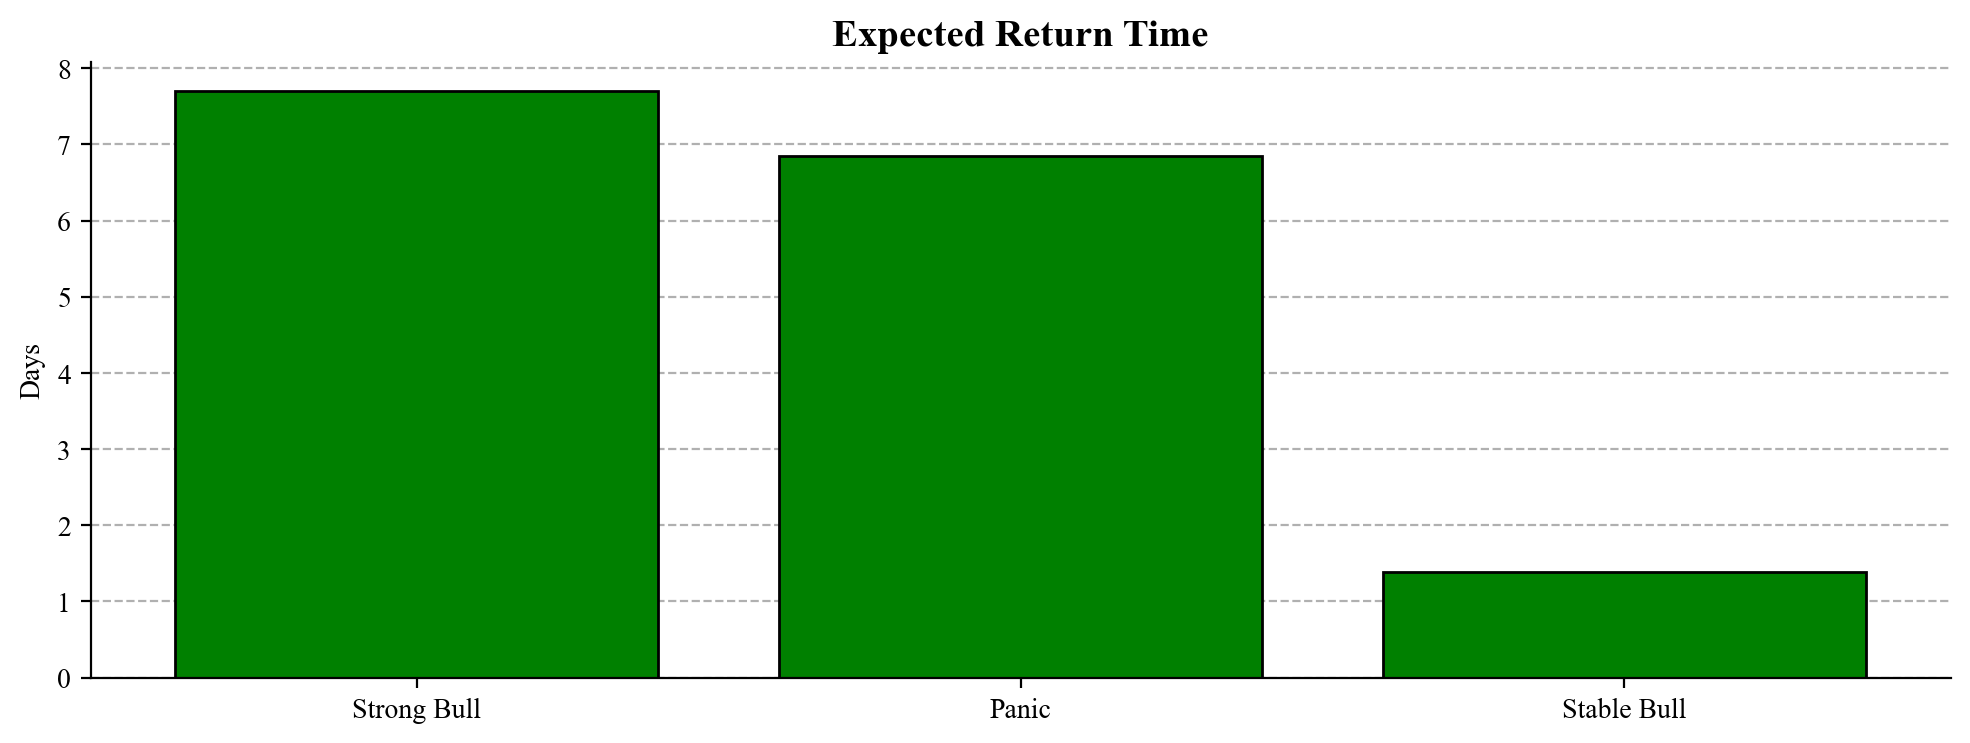

In [14]:
plt.figure(figsize=(12,4), dpi=200)
plt.bar(groups_names, expected_rt, color='g', edgecolor='k', zorder=2)

plt.xticks(range(3))
plt.ylabel('Days')

plt.title('Expected Return Time', size=14, weight='bold')

plt.grid(ls='--', axis='y', zorder=0)
sns.despine()
plt.show()